In [1]:
import numpy as np
import itertools

In [2]:

class RBM:
    def __init__(self, v_dim, h_dim, lr=10e-2, gibbs_num=15):
        self.v_dim = v_dim
        self.h_dim = h_dim
        self.lr = lr
        self.v_bias = np.random.normal(size = (1,self.v_dim))
        self.h_bias = np.random.normal(size =(1,self.h_dim))
        self.W = np.random.normal(size = (self.v_dim, self.h_dim))
        self.gibbs_num = gibbs_num

    
    # when a input vector V is recieved, p(h=1|v) can be computed
    # using the activition probability, the states of hidden layer could be sampled
    def sample_h(self, v_input):
        p_h_v = 1/(1 + np.exp(-(np.dot(v_input, self.W) + self.h_bias)))
        state_h = self.state_sample(p_h_v)

        return state_h, p_h_v
    
    # in constract, once the states of hidden layer are obtained, p(v=1|h) can be computed
    # with probability, the states of visible layer could be sampled 
    def sample_v(self, h):
        p_v_h = 1/(1 + np.exp(-(np.dot(h, self.W.T) + self.v_bias)))
        state_v = self.state_sample(p_v_h)
        
        return state_v, p_v_h

    def state_sample(self, p):
        state = []
        uni = np.random.uniform(0,1, size=p[0].shape[0])
        for i in range(len(p)):
            condition = np.less(p[i], uni)
            state_node = np.where(condition, 0, 1)
            state.append(state_node)
        return np.array(state).reshape(p.shape[0], p.shape[1])

    # taking use of the visible layer state V(i) and probability p(v|h), k'th V state could be computed 
    # and its corresponding p(h(k)|V).
    def gibbs_sampling(self, v):
        i = 0 
        k = self.gibbs_num
        v_0 = v

        _, p_h0_v = self.sample_h(v_0)

        while bool(i < k):
            state_h, _ = self.sample_h(v)
            state_v, _ = self.sample_v(state_h)
            i += 1
            state_v[v0 < 0] = v_0[v0 < 0]
        else: 
            v_k = state_v
            v_k[v0 < 0] = v_0[v0 < 0]
            _, p_hk_v = self.sample_h(v_k)
        
        return v_0, v_k, p_h0_v, p_hk_v
        

    # with the refered formulas, the gradient of each parameter(W, b-->h, a-->v) could be computed
    def gradient_compute(self, v_0, v_k, p_h0_v, p_hk_v):
        dw = np.dot(v_0.T, p_h0_v) - np.dot(v_k.T, p_hk_v)
        dh_bias = np.sum(p_h0_v - p_hk_v)
        dv_bias = np.sum(v_0 - v_k)
        
        self.W += self.lr * dw
        self.v_bias += self.lr * dv_bias
        self.h_bias += self.lr * dh_bias  
    # set the number of iteration and go over all the training data (binary vectors) for one epoch.

In [3]:
def compute_Z(v_dimension, h_dimension, W, v_bias, h_bias):
    W = W
    v_bias = v_bias
    h_bias = h_bias
    def compute_E(v,h):
        return np.exp(np.dot(np.dot(v, W), h.T) + np.dot(v, v_bias.T) + np.dot(h, h_bias.T))
    
    def dic_build(dic_candidate, dim):
        i= 0
        for item in itertools.product('01',repeat=dim):
            if i not in dic_candidate:
                dic_candidate[i] = item
            i += 1
            
        return dic_candidate
    

    dic_h = {}
    dic_v = {}
    
    dic_h = dic_build(dic_h, h_dimension)
    dic_v = dic_build(dic_v, v_dimension)

    dic_Z = {}
    ss = -1
    for i in range(len(dic_h)):
        for j in range(len(dic_v)):
            ss += 1
            if ss not in dic_Z:
                dic_Z[ss] = (dic_h[i], dic_v[j]) 

    Z = 0
    for i in range(len(dic_Z)):
        h_nodes = np.array(dic_Z[i][0]).astype(float)
        v_nodes = np.array(dic_Z[i][1]).astype(float)
        nodes = (v_nodes, h_nodes)
        Z  += compute_E(*nodes)

        #print('{}: => Z={}, logZ={}'.format(i, Z[0], np.log(Z[0])))
    return Z


def compute_px_with_Z(train_data_one_piece, W, v_bias, h_bias): 
    for i in range(h_bias.shape[1]):
        product_value = 1
        product_value = product_value * (np.exp(np.dot(train_data_one_piece,W.T[i]) + h_bias.T[i]) + 1)
        first_item = np.exp(np.dot(v_bias, train_data_one_piece.T))
        px_with_Z = first_item * product_value

    return px_with_Z

In [4]:
train_data = np.loadtxt(r'C:\Users\86185\Desktop\master thesis\data\Bars-and-Stripes-3x3.txt')

visible_node_num = train_data.shape[1]
hidden_node_num = 5
lr = 10e-5
gibbs_num = 50

epochs = 100
batch_size = 1

In [8]:
rbm = RBM(visible_node_num, hidden_node_num, lr, gibbs_num)

In [9]:
KL_list = []
log_LKH_list = []

for epoch in range(epochs):
    for index in range(0, train_data.shape[0]-batch_size, batch_size):
        v0 = train_data[index: index + batch_size]
        vk = train_data[index: index + batch_size]
        _, p_h0_v = rbm.sample_h(v0)
        v0, vk, p_h0_v, p_hk_v = rbm.gibbs_sampling(v0)
        rbm.gradient_compute(v0, vk, p_h0_v, p_hk_v)
    
    Z = compute_Z(visible_node_num, hidden_node_num, rbm.W, rbm.v_bias, rbm.h_bias)
    logLKH = 0
    KL = 0
    for i in range(len(train_data)):
        px_with_Z = compute_px_with_Z(train_data[i], rbm.W, rbm.v_bias, rbm.h_bias)
        
        log_lkh = np.log(px_with_Z) - np.log(Z)
        logLKH += log_lkh

        kl = -np.log(len(train_data))/len(train_data) - np.log(px_with_Z)/len(train_data) + np.log(Z)/len(train_data)
        KL += kl
    KL /= len(train_data)
    logLKH /= len(train_data)
    KL_list.append(KL)
    log_LKH_list.append(logLKH)
    
    print('epoch:{} ==>  KL = {}, logLKH = {} sum = {}'.format(epoch+1, KL, logLKH, KL+logLKH))

    #if(epoch % 10 == 0):
        #print('Epoch:{0:4d} KL_divergence:{1:1.4f}'.format(epoch, KL_divergence_epoch))




epoch:1 ==>  KL = [0.93942697], logLKH = [-15.79103494] sum = [-14.85160796]
epoch:2 ==>  KL = [0.93869747], logLKH = [-15.78082189] sum = [-14.84212443]
epoch:3 ==>  KL = [0.93808961], logLKH = [-15.77231189] sum = [-14.83422228]
epoch:4 ==>  KL = [0.93742532], logLKH = [-15.76301175] sum = [-14.82558643]
epoch:5 ==>  KL = [0.93677056], logLKH = [-15.75384519] sum = [-14.81707463]
epoch:6 ==>  KL = [0.93620221], logLKH = [-15.74588831] sum = [-14.8096861]
epoch:7 ==>  KL = [0.93555639], logLKH = [-15.73684684] sum = [-14.80129044]
epoch:8 ==>  KL = [0.93484483], logLKH = [-15.72688491] sum = [-14.79204008]
epoch:9 ==>  KL = [0.93425047], logLKH = [-15.71856385] sum = [-14.78431339]
epoch:10 ==>  KL = [0.93371697], logLKH = [-15.71109494] sum = [-14.77737797]
epoch:11 ==>  KL = [0.93313654], logLKH = [-15.70296889] sum = [-14.76983235]
epoch:12 ==>  KL = [0.93274358], logLKH = [-15.69746739] sum = [-14.76472381]
epoch:13 ==>  KL = [0.93242354], logLKH = [-15.69298694] sum = [-14.760563

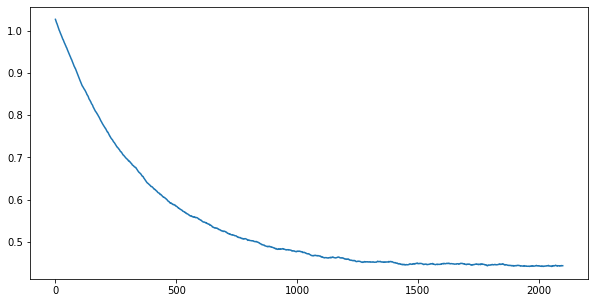

In [29]:
import matplotlib.pyplot as plt

time = [i for i in range(len(KL_list))]
plt.figure(figsize=(10,5))
plt.plot(time, KL_list)
#plt.savefig('KL_divergence')
plt.show()

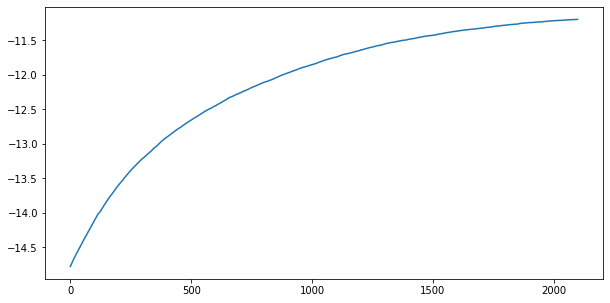

In [30]:
plt.figure(figsize=(10,5))
plt.plot(time, log_LKH_list)
#plt.savefig('log_Likelihood')
plt.show()